In [1]:
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import random

%load_ext autoreload

In [2]:
%autoreload 2
from classes.fpst import *

In [3]:
if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")

dir = os.path.join(data_dir, "SPST_perfect")

In [4]:
file = loadmat(os.path.join(dir, "FPSTdata_2_pol-60.mat"))

fpsts_26 = file["fpsts"]
forbiden = file["forbiden"][0]
coords_26 = file["coords"]

fpsts_26 = fpsts_26[:10000]
coords_26 = coords_26[:10000]

In [5]:
from PIL import Image

fpsts_32 = np.empty((len(fpsts_26), 32, 32))
for i in range(len(fpsts_26)):
    # Interpolate the map to 32x32 using the nearest neighbour method
    fpsts_32[i] = np.array(Image.fromarray(fpsts_26[i]).resize((32, 32), resample=Image.NEAREST))

# free memory
del fpsts_26

In [6]:
dir_path = os.path.join(data_dir, "interpol_64", "FPST_3MI2_-60")
total_tasks = 10000 #(512 * 512)

fpsts_64, coords_64 = load_FPST(dir_path, total_tasks)

Overhead done, starting the loop


Process: 100%|██████████| 10000/10000 [00:15<00:00, 629.07task/s]


In [15]:
fpsts_32 = map(process, fpsts_32)
fpsts_64 = map(process, fpsts_64)

fpsts_32 = np.array(list(fpsts_32))
fpsts_64 = np.array(list(fpsts_64))

max_32 = np.max(fpsts_32)
min_32 = np.min(fpsts_32)
fpsts_32 = (fpsts_32 - min_32) / (max_32 - min_32)

max_64 = np.max(fpsts_64)
min_64 = np.min(fpsts_64)
fpsts_64 = (fpsts_64 - min_64) / (max_64 - min_64)

In [154]:
""" fpsts_26 = fpsts_26 * (max_26 - min_26) + min_26
fpsts_64 = fpsts_64 * (max_64 - min_64) + min_64

fpsts_26 = map(rev_process, fpsts_26)
fpsts_64 = map(rev_process, fpsts_64)

fpsts_26 = np.array(list(fpsts_26))
fpsts_64 = np.array(list(fpsts_64)) """

In [54]:
""" ind = random.randint(0, len(fpsts_64))
print(ind)

fpst_32 = fpsts_32[ind]
fpst_64 = fpsts_64[ind]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fpst_32, cmap="jet")
axs[0].set_title("32x32")
axs[1].imshow(fpst_64, cmap="jet")
axs[1].set_title("64x64")
plt.show() """

' ind = random.randint(0, len(fpsts_64))\nprint(ind)\n\nfpst_32 = fpsts_32[ind]\nfpst_64 = fpsts_64[ind]\n\nfig, axs = plt.subplots(1, 2, figsize=(10, 5))\naxs[0].imshow(fpst_32, cmap="jet")\naxs[0].set_title("32x32")\naxs[1].imshow(fpst_64, cmap="jet")\naxs[1].set_title("64x64")\nplt.show() '

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(fpsts_32[:total_tasks], fpsts_64, test_size=0.2, random_state=42)

In [20]:
X_train = np.expand_dims(X_train, axis=-1)
Y_train = np.expand_dims(Y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

In [55]:
from classes.models_fpst import get_basic_cnn

In [57]:
""" basic_cnn = get_basic_cnn([32, 64, 128], (32, 32), (64, 64))
basic_cnn.compile(optimizer='adam', loss='mse')
basic_cnn.summary() """

" basic_cnn = get_basic_cnn([32, 64, 128], (32, 32), (64, 64))\nbasic_cnn.compile(optimizer='adam', loss='mse')\nbasic_cnn.summary() "

In [48]:
# Load the model

#model = keras.models.load_model(os.path.join(model_dir, "FPST_32_64_basic_conv.h5"))

In [42]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 250s 1s/step - loss: 0.0026 - val_loss: 3.8518e-04
Epoch 2/10
200/200 [==============================] - 233s 1s/step - loss: 4.5736e-04 - val_loss: 0.0015
Epoch 3/10
200/200 [==============================] - 238s 1s/step - loss: 2.9750e-04 - val_loss: 1.9572e-04
Epoch 4/10
200/200 [==============================] - 233s 1s/step - loss: 1.9857e-04 - val_loss: 1.7737e-04
Epoch 5/10
200/200 [==============================] - 233s 1s/step - loss: 1.4501e-04 - val_loss: 1.1375e-04
Epoch 6/10
200/200 [==============================] - 234s 1s/step - loss: 1.3553e-04 - val_loss: 1.3529e-04
Epoch 7/10
200/200 [==============================] - 236s 1s/step - loss: 1.3485e-04 - val_loss: 1.4513e-04
Epoch 8/10
200/200 [==============================] - 235s 1s/step - loss: 1.1634e-04 - val_loss: 2.0774e-04
Epoch 9/10
200/200 [==============================] - 237s 1s/step - loss: 1.1981e-04 - val_loss: 1.0764e-04
Epoch 10/10
200/200 [======

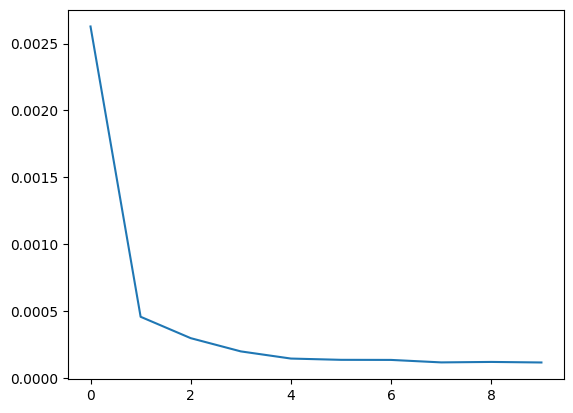

In [43]:
# Plot the history in log scale
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, Y_test)
print("Loss: ", loss)

# Evaluate the model with structural similarity index
from skimage.metrics import structural_similarity as ssim

def ssim_loss(y_true, y_pred):
    return 1 - ssim(y_true, y_pred)

ssim_loss = model.evaluate(X_test, Y_test, ssim_loss)

1/1 [==============================] - 0s 36ms/step
(64, 64)


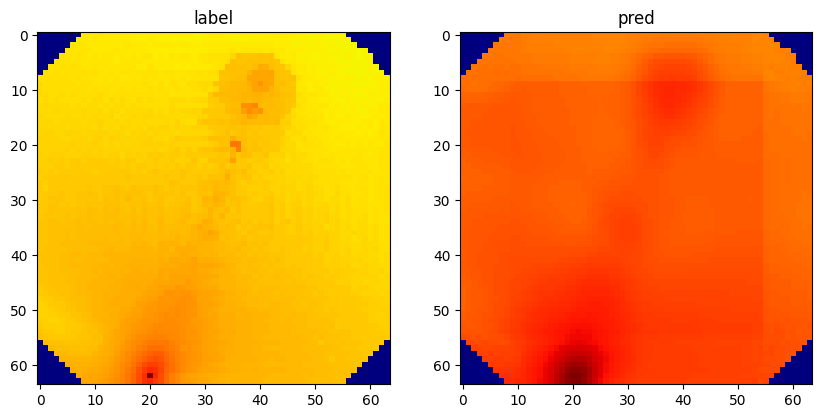

In [51]:
ind = random.randint(0, X_test.shape[0]-1)
pred = model.predict(X_test[ind:ind+1])[0,:,:,0]
print(pred.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(Y_test[ind], cmap="jet")
axs[0].set_title("label")
axs[1].imshow(pred, cmap="jet")
axs[1].set_title("pred")
plt.show()

In [47]:
# Save the model

model_dir = os.path.join(root_dir, "models")
model.save(os.path.join(model_dir, "FPST_32_64_basic_conv.h5"))

c:\Users\f076048\Documents\Stage_CSL\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
